# Overview:

The goal of this analysis is to examine whether there is evidence for classroom transmission. We run a logistic regression to predict infection status based on several features, including:
* fraction of classes positive (to explain)
* greek and athlete affiliations,
* ...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import pandas as pd

In [3]:
all_students_features = pd.read_csv('do_not_touch/all_students_features_trunc_corrected.csv')
# we only use the "positives_identified_on_this_day" column in this df
# class positivity isn't filled into this df yet, it exists separately; we will combine them later

In [4]:
all_students_features.head()

,Unnamed: 0,employee_id_hash,is_greek,is_athlete,academic_career,academic_plan1,hd_notify_date,day_idx,positives_identified_on_this_day,infected_on_this_day,previous_infection,week_idx,biweek_idx,class_prevalence_on_this_day
0,0,0x0001CEED0A3584312155FD3B695D2EB6,0,0,UG,ESAG-BS,NaN,2021-08-26,23,0,0,0,0,NaN
1,1,0x0001CEED0A3584312155FD3B695D2EB6,0,0,UG,ESAG-BS,NaN,2021-08-27,43,0,0,0,0,NaN
2,2,0x0001CEED0A3584312155FD3B695D2EB6,0,0,UG,ESAG-BS,NaN,2021-08-28,57,0,0,0,0,NaN
3,3,0x0001CEED0A3584312155FD3B695D2EB6,0,0,UG,ESAG-BS,NaN,2021-08-29,55,0,0,0,0,NaN
4,4,0x0001CEED0A3584312155FD3B695D2EB6,0,0,UG,ESAG-BS,NaN,2021-08-30,39,0,0,0,0,NaN


In [ ]:
# construct a list of "true positives" on each day
# 1. get the time series for `positives_identified_on_this_day` for one person (since it's the same for all people)
# 2. compute the running sum that accounts for underlying positives, i.e., positives identified on neighboring days

In [5]:
emplid = '0x0001CEED0A3584312155FD3B695D2EB6'
hd_positives_all = all_students_features.query('employee_id_hash == @emplid')[['day_idx','positives_identified_on_this_day']]

In [6]:
hd_positives_all

,day_idx,positives_identified_on_this_day
0,2021-08-26,23
1,2021-08-27,43
2,2021-08-28,57
3,2021-08-29,55
4,2021-08-30,39
...,...,...
99,2021-12-03,14
100,2021-12-04,0
101,2021-12-05,7
102,2021-12-06,12


In [7]:
hd_positives_all['underlying_pos'] = ''
hd_positives_all['underlying_pos_forward_backward'] = ''

# TODO: later we want to do sensitivity analysis on this 7 number

for t in range(104):
    hd_positives_all.at[t,'underlying_pos']=sum(hd_positives_all['positives_identified_on_this_day'][t:min(104,t+7)])
    hd_positives_all.at[t,'underlying_pos_forward_backward']=sum(hd_positives_all['positives_identified_on_this_day'][max(0,t-6):min(104,t+7)])

In [11]:
hd_positives_all.head()

,day_idx,positives_identified_on_this_day,underlying_pos,underlying_pos_forward_backward
0,2021-08-26,23,296,296
1,2021-08-27,43,315,338
2,2021-08-28,57,298,364
3,2021-08-29,55,270,393
4,2021-08-30,39,219,397


In [8]:
all_students_features['underlying_positives_on_this_day'] = ''
all_students_features['underlying_positives_on_this_day_forward_backward'] = ''

In [14]:
for idx, row in all_students_features.iterrows():
    day_idx = row['day_idx']
    if row['infected_on_this_day']:
        all_students_features.at[idx, 'underlying_positives_on_this_day'] = \
            float(hd_positives_all[hd_positives_all['day_idx'] == day_idx]['underlying_pos'].item() - 1)
        all_students_features.at[idx, 'underlying_positives_on_this_day_forward_backward'] = \
            float(hd_positives_all[hd_positives_all['day_idx'] == day_idx]['underlying_pos_forward_backward'].item() - 1)
    else:
        all_students_features.at[idx, 'underlying_positives_on_this_day'] = \
            float(hd_positives_all[hd_positives_all['day_idx'] == day_idx]['underlying_pos'].item())
        all_students_features.at[idx, 'underlying_positives_on_this_day_forward_backward'] = \
            float(hd_positives_all[hd_positives_all['day_idx'] == day_idx]['underlying_pos_forward_backward'].item())


In [18]:
res = all_students_features[['underlying_positives_on_this_day', 'underlying_positives_on_this_day_forward_backward']]
res.head()

,underlying_positives_on_this_day,underlying_positives_on_this_day_forward_backward
0,296,296
1,315,338
2,298,364
3,270,393
4,219,397


In [21]:
res.rename(columns = {
    "underlying_positives_on_this_day": "campus_positivity_backward",
    "underlying_positives_on_this_day_forward_backward": "campus_positivity_forward_backward"
}, inplace=True)

C:\Users\yz685\Anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [24]:
res.to_csv('do_not_touch/campus_positivity.csv')

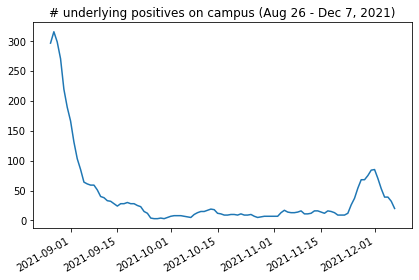

In [29]:
import matplotlib.dates as dates

idx = pd.date_range('2021-08-26', '2021-12-07')

# plot backward campus positivity

fig, ax = plt.subplots()
ax.plot_date(idx.to_pydatetime(), hd_positives_all['underlying_pos'], '-')
plt.gcf().autofmt_xdate()
plt.title('# underlying positives on campus (Aug 26 - Dec 7, 2021)')

plt.tight_layout()
plt.show()

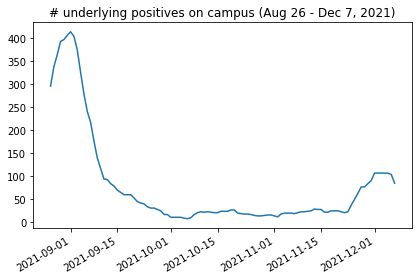

In [30]:
# plot forward-backward campus positivity

fig, ax = plt.subplots()
ax.plot_date(idx.to_pydatetime(), hd_positives_all['underlying_pos_forward_backward'], '-')
plt.gcf().autofmt_xdate()
plt.title('# underlying positives on campus (Aug 26 - Dec 7, 2021)')

plt.tight_layout()
plt.show()

In [32]:
hd_positives_all['underlying_pos_forward_backward'].mean()

78.59615384615384

In [34]:
hd_positives_all['underlying_pos_forward_backward'].std()

107.69054183445017